In [1]:
import os
import requests
import json
import json

from typing import List, Set
from anthropic import Anthropic
from bs4 import BeautifulSoup, Comment
from dataclasses import dataclass
from typing import Optional
from urllib.parse import urlparse, urljoin

import undetected_chromedriver as uc
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By

In [2]:
@dataclass
class JobOpening:
    id: str
    title: str
    location: Optional[str]
    link: str
    related: bool

In [3]:
PARSE_HTML_SYSTEM_PROMPT = """Your job is to parse html and return structured data as requested. You parse the full document and return all the results. Provide only the answer, with no additional text or explanation."""
PARSE_OPENINGS_LINK_PROMPT = """
This is the html content of the {} careers page. This html is either contains a list of job openings, or a link to the list of openings/roles/positions/jobs. Return the link to the page containing openings/roles/positions/jobs. If the current page contains the list then simply return the current link.
Dp not acknowledge this request, simply return only the link, with no additional text or explanation.
"""
PARSE_OPENINGS_PROMPT = """
This is the html content of the {} careers page containing a list of list of openings/roles/positions/jobs, each with a link. Parse the page and return a list of openings with the title of the opening, the link to the specific job page, and the location (if available). Also return a boolean field called related.
Related should return 'True' if the the specific job is related to the criteria {} and 'False' if unrelated. Return the results as a list of json with the keys "title", "link", "location", and "related".
Provide only the JSON, with no additional text or explanation.
"""

In [10]:
SERPDOG_API_KEY = os.getenv('SERPDOG_API_KEY')
ANTHROPIC_API_KEY = os.getenv('CLAUDE_API_KEY')
PROSPECT_API_KEY = os.getenv('PROSPECT_API_KEY')
print(PROSPECT_API_KEY)

554d5e43-4150-4f71-a134-7ab2a2d91308


{"meta":{"api_key":"66c0f8f964e55443ffdb1ef7","q":"anduril careers","gl":"us"},"user_credits_info":{"quota":1000,"requests":80,"requests_left":920},"search_information":{"total_results":"About 3,670,000 results (0.22 seconds)","query_displayed":"anduril careers"},"menu_items":[{"title":"News","link":"https://www.google.com/search?sca_esv=af551f653f51ea9a&gl=us&hl=en&q=anduril+careers&tbm=nws&source=lnms&fbs=AEQNm0Aa4sjWe7Rqy32pFwRj0UkWd8nbOJfsBGGB5IQQO6L3J5MIFhvnvU242yFxzEEp3BfblMs7eBu5zPnhtGsrETMyhOqzWtfgc_pCzrf4BYocXLJaX0gJBEKL77s1Ay-4tHfnMqP5vC_ZT8lpSywyzIaNxlK3h27DKyjP4cAIPUhzalTbEILgzj9kP6BqoP0xWu6yYBTYByfUljVA60k5fyr5AlSneg&sa=X&ved=2ahUKEwjs37exrYCIAxU21AIHHT4oAvEQ0pQJegQIERAB","position":1},{"title":"Videos","link":"https://www.google.com/search?sca_esv=af551f653f51ea9a&gl=us&hl=en&q=anduril+careers&tbm=vid&source=lnms&fbs=AEQNm0Aa4sjWe7Rqy32pFwRj0UkWd8nbOJfsBGGB5IQQO6L3J5MIFhvnvU242yFxzEEp3BfblMs7eBu5zPnhtGsrETMyhOqzWtfgc_pCzrf4BYocXLJaX0gJBEKL77s1Ay-4tHfnMqP5vC_ZT8lpSywyzIaNx
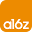
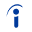
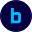

In [5]:
payload = {'api_key': SERPDOG_API_KEY, 'q':'anduril careers' , 'gl':'us'}
resp = requests.get('https://api.serpdog.io/search', params=payload)
print (resp.text)

In [7]:
results = json.loads(resp.text)['organic_results']

In [8]:
results[0]

{'title': 'Careers - Anduril',
 'link': 'https://www.anduril.com/careers/',
 'displayed_link': 'https://www.anduril.com › careers',
 'favicon': '',
 'source': 'Anduril',
 'snippet': 'Anduril is not a traditional defense contractor. We privately fund our R&D and sell finished products off the shelf, meaning we emphasize speed and results. If\xa0...',
 'highlighted_keywords': ['Anduril'],
 'extended_sitelinks': [{'title': 'Open Roles',
   'link': 'https://www.anduril.com/open-roles/',
   'snippet': 'Finance & Accounting. Accounts Receivable · Altius. ALTIUS ...'},
  {'title': 'Emerging Talent',
   'link': 'https://www.anduril.com/internships-at-anduril/',
   'snippet': 'Careers · Leadership · Newsroom · Blog · Media · Twitter · LinkedIn ...'},
  {'title': 'Anduril Leadership',
   'link': 'https://www.anduril.com/leadership/',
   'snippet': 'Careers · Leadership · Newsroom · Blog · Media · Twitter · LinkedIn ...'}],
 'rank': 1}

In [ ]:
chrome_options = Options()
chrome_options.add_argument("--headless")  # Run headless Chrome
chrome_options.add_argument("--no-sandbox")
chrome_options.add_argument("--disable-dev-shm-usage")

driver = uc.Chrome(options=chrome_options)
driver.get('https://www.anduril.com/careers/')

# Wait for the page to load completely (this can be adjusted as needed)
driver.implicitly_wait(2)

# Extract text content from the body or specific elements
# content = driver.find_element(By.TAG_NAME, "body").text

def get_page_source(url):
    chrome_options = Options()
    chrome_options.add_argument("--headless")  # Run headless Chrome
    chrome_options.add_argument("--no-sandbox")
    chrome_options.add_argument("--disable-dev-shm-usage")
    
    driver = uc.Chrome(options=chrome_options)
    driver.get(url)

    # Wait for JavaScript to finish loading
    print("Waiting for javascript to finish loading")
    WebDriverWait(driver, 10).until(
        lambda d: d.execute_script("return document.readyState") == "complete"
    )
    print("Done.")
    
    # Wait for the page to load completely (this can be adjusted as needed)
    driver.implicitly_wait(2)
    
    # Extract text content from the body or specific elements
    # content = driver.find_element(By.TAG_NAME, "body").text

    return driver.page_source

In [ ]:
len(driver.page_source)

# LLM Service

In [ ]:
def strip_html(soup):
    for tag in soup(["script", "style", "iframe"]):
        tag.decompose()

    # Iterate over all elements in the soup
    for tag in soup.find_all(True):
        # Remove the class attribute from each tag
        tag.attrs.pop("class", None)

    # List of attributes to preserve
    preserve_attrs = ["id", "href", "datetime"]

    # Iterate over all elements in the soup
    for tag in soup.find_all(True):
        # Get the attributes of the current tag
        attrs = tag.attrs.copy()  # Copy to avoid modifying while iterating

        # Remove all attributes except the ones in preserve_attrs
        for attr in attrs:
            if attr not in preserve_attrs:
                tag.attrs.pop(attr, None)

    # Remove all comments
    for comment in soup.find_all(string=lambda text: isinstance(text, Comment)):
        comment.extract()

    return soup

def fetch_all_links_from_webpage(self, soup):
    # Return the href attribute from each <a> tag
    links = soup.find_all("a")
    return set([link.get("href") for link in links if link.get("href")])

def resolve_url(base_url, link):
    # Parse the link
    parsed_link = urlparse(link)
    
    # Check if the link is relative (it doesn't have a scheme or netloc)
    if not parsed_link.scheme and not parsed_link.netloc:
        # Combine it with the base URL
        combined_url = urljoin(base_url, link)
        return combined_url
    else:
        # The link is absolute
        return link


class LLMService:
    def __init__(self, anthropic_api_key: str):
        self.client = Anthropic(api_key=anthropic_api_key)

    def create_message(self, prompt, system_prompt, model, temperature, max_tokens):
        message = self.client.messages.create(
            model=model,
            temperature=temperature,
            max_tokens=max_tokens,
            system=system_prompt,
            messages=[{"role": "user", "content": [{"type": "text", "text": prompt}]}],
        )
        return message.content[0].text

    def parse_openings_from_html(self, company: str, job_type: str, raw_html: str) -> List[JobOpening]:
        prompt = f"{raw_html}\n\n {PARSE_OPENINGS_PROMPT}".format(company, job_type)
        text_responses = self.create_message(
            PARSE_HTML_SYSTEM_PROMPT,
            prompt,
            model="claude-3-5-sonnet-20240620",
            temperature=0.1,
            max_tokens=4096,
        )
        print(text_responses)
        json_response = json.loads(text_responses)
        print(json_response)
        return [
            JobOpening(id=str(idx), **json_object)
            for idx, json_object in enumerate(json_response)
        ]

    def parse_openings_page_link_from_html(self, company: str, raw_html: str) -> Optional[str]:
        prompt = f"{raw_html}\n\n {PARSE_OPENINGS_LINK_PROMPT}".format(company)
        return self.create_message(
            PARSE_HTML_SYSTEM_PROMPT,
            prompt,
            model="claude-3-5-sonnet-20240620",
            temperature=0.1,
            max_tokens=4096,
        )

# Find Postings

In [ ]:
soup = BeautifulSoup(driver.page_source, "html.parser")

In [ ]:
cleaned_html = str(strip_html(soup))
print(len(cleaned_html))

openings_link = llm_service.parse_openings_page_link_from_html("anduril", cleaned_html)
openings_link

In [ ]:
full_url = resolve_url("https://www.anduril.com/careers/", openings_link)

In [ ]:
llm_service = LLMService(ANTHROPIC_API_KEY)
page_source = get_page_source(full_url)
soup = BeautifulSoup(page_source, "html.parser")
cleaned_html = str(strip_html(soup))
job_openings = llm_service.parse_openings_from_html("anduril", "software engineer", cleaned_html)
job_openings

# Find People

In [ ]:
base_url = 'https://linkedin.com/in/'
company = "anduril"
position = "software engineering manager"
query = f"site:{base_url} {company} {position}"
print(query)

In [ ]:
payload = {'api_key': SERPDOG_API_KEY, 'q': query , 'gl':'us'}
resp = requests.get('https://api.serpdog.io/search', params=payload)

In [ ]:
print(resp.text)

In [ ]:
[(res['title'], res['link']) for res in json.loads(resp.text)['organic_results']]

In [ ]:
test = [('Michael Nowak - Anduril Industries',
  'https://www.linkedin.com/in/michael-nowak-ba332567'),
 ('Mike Glazer - Anduril Industries',
  'https://www.linkedin.com/in/mike-glazer-5a885bb'),
 ('Julien Faro - Software Engineer - Anduril Industries',
  'https://www.linkedin.com/in/julien-faro'),
 ('Thomas Weaver - Mission Software Engineer',
  'https://www.linkedin.com/in/thomas-weaver-sw'),
 ('Varun Murthy - Mission Software Engineer',
  'https://www.linkedin.com/in/varun-murthy-a9a4ba20a'),
 ('Nabil Enayet - Anduril Industries',
  'https://www.linkedin.com/in/nabilenayet'),
 ('Spencer Fishman - Anduril Industries',
  'https://www.linkedin.com/in/spencerfishman'),
 ('Shane Arnott - Anduril Industries',
  'https://www.linkedin.com/in/shanearnott'),
 ('John Hottinger - Anduril Industries',
  'https://www.linkedin.com/in/jhottinger'),
 ('Benjamin Colebrook - Software Engineer at Anduril',
  'https://www.linkedin.com/in/benjamin-colebrook')]

In [ ]:
# url = "https://api.getprospect.com/public/v1/email/find?name={}&company={}"
linkedin_search_url = 'https://api.getprospect.com/public/v1/insights/contact?linkedinUrl={}&apiKey={}'
headers = {"accept": "application/json", }
for title, link in test:
    print(title)
    print(link)

In [ ]:
link = test[0][1]
response = requests.get(linkedin_search_url.format(link, PROSPECT_API_KEY))
print(response)

In [30]:
name = json.loads(response.text)['firstName'] + ' ' + json.loads(response.text)['lastName']
url = "https://api.getprospect.com/public/v1/email/find?name={}&company={}&apiKey={}"

print(company)
print(PROSPECT_API_KEY)
print(name)
response = requests.get(url.format(name, company, PROSPECT_API_KEY), headers=headers)

anduril
554d5e43-4150-4f71-a134-7ab2a2d91308
Michael Nowak


In [31]:
response

<Response [200]>

In [32]:
response.text

'{"email":"mnowak@anduril.com","status":"accept_all"}'

In [17]:

class ScrapingService:

    def __init__(self, anthropic_api_key: str):
        self.client = Anthropic(api_key=anthropic_api_key)

    @staticmethod
    def strip_html(soup):
        for tag in soup(["script", "style", "iframe"]):
            tag.decompose()

        # Iterate over all elements in the soup
        for tag in soup.find_all(True):
            # Remove the class attribute from each tag
            tag.attrs.pop("class", None)

        # List of attributes to preserve
        preserve_attrs = ["id", "href", "datetime"]

        # Iterate over all elements in the soup
        for tag in soup.find_all(True):
            # Get the attributes of the current tag
            attrs = tag.attrs.copy()  # Copy to avoid modifying while iterating

            # Remove all attributes except the ones in preserve_attrs
            for attr in attrs:
                if attr not in preserve_attrs:
                    tag.attrs.pop(attr, None)

        # Remove all comments
        for comment in soup.find_all(string=lambda text: isinstance(text, Comment)):
            comment.extract()

        return soup

    @staticmethod
    def fetch_all_links_from_webpage(soup):
        # Return the href attribute from each <a> tag
        links = soup.find_all("a")
        return set([link.get("href") for link in links if link.get("href")])

    @staticmethod
    def resolve_url(base_url, link):
        # Parse the link
        parsed_link = urlparse(link)

        # Check if the link is relative (it doesn't have a scheme or netloc)
        if not parsed_link.scheme and not parsed_link.netloc:
            # Combine it with the base URL
            combined_url = urljoin(base_url, link)
            return combined_url
        else:
            # The link is absolute
            return link

    @staticmethod
    def get_page_source(url):
        chrome_options = Options()
        chrome_options.add_argument("--headless")  # Run headless Chrome
        chrome_options.add_argument("--no-sandbox")
        chrome_options.add_argument("--disable-dev-shm-usage")

        driver = uc.Chrome(options=chrome_options)
        driver.get(url)

        # Wait for JavaScript to finish loading
        print("Waiting for javascript to finish loading")
        WebDriverWait(driver, 10).until(
            lambda d: d.execute_script("return document.readyState") == "complete"
        )
        print("Done.")

        # Wait for the page to load completely (this can be adjusted as needed)
        driver.implicitly_wait(2)

        # Extract text content from the body or specific elements
        # content = driver.find_element(By.TAG_NAME, "body").text
        page_source = driver.page_source

        driver.quit()

        return page_source

    def create_message(
        self, prompt, system_prompt, model, temperature, max_tokens
    ) -> str:
        message = self.client.messages.create(
            model=model,
            temperature=temperature,
            max_tokens=max_tokens,
            system=system_prompt,
            messages=[{"role": "user", "content": [{"type": "text", "text": prompt}]}],
        )
        return message.content[0].text

    @staticmethod
    def parse_openings_from_html(
        company: str, job_type: str, raw_html: str
    ) -> List[JobOpening]:
        prompt = f"{raw_html}\n\n {PARSE_OPENINGS_PROMPT}".format(company, job_type)
        text_responses = self.create_message(
            PARSE_HTML_SYSTEM_PROMPT,
            prompt,
            model="claude-3-5-sonnet-20240620",
            temperature=0.1,
            max_tokens=4096,
        )
        print(text_responses)
        json_response = json.loads(text_responses)
        print(json_response)
        return [
            JobOpening(id=str(idx), **json_object)
            for idx, json_object in enumerate(json_response)
        ]

    def parse_openings_page_link_from_html(
        self, company: str, raw_html: str
    ) -> Optional[str]:
        # print(f"Raw HTML: {raw_html}")
        print(f"Parsing openings page link from html for {company}")
        prompt = f"{raw_html}\n\n {PARSE_OPENINGS_LINK_PROMPT}".format(company)
        print()
        return self.create_message(
            PARSE_HTML_SYSTEM_PROMPT,
            prompt,
            model="claude-3-5-sonnet-20240620",
            temperature=0.1,
            max_tokens=4096,
        )

scraping_service = ScrapingService(ANTHROPIC_API_KEY)


In [ ]:
html_source = scraping_service.get_page_source(url="https://www.anduril.com/careers")
len(html_source)

In [48]:
soup = BeautifulSoup(html_source, "html.parser")
[{'text': a_tag.get_text(), 'link': a_tag.get('href')} for a_tag in soup.find_all('a')]

[{'text': ' Anduril', 'link': '/'},
 {'text': 'Command & Control', 'link': '/command-and-control/'},
 {'text': 'Mission Autonomy', 'link': '/mission-autonomy/'},
 {'text': 'Counter UAS', 'link': '/capability/counter-uas/'},
 {'text': 'Counter Intrusion', 'link': '/capability/land/'},
 {'text': 'Maritime Counter Intrusion', 'link': '/capability/Sea/'},
 {'text': 'Roadrunner', 'link': '/roadrunner/'},
 {'text': 'Fury', 'link': '/fury/'},
 {'text': 'Ghost', 'link': '/hardware/ghost-autonomous-suas/'},
 {'text': 'Altius', 'link': '/hardware/altius/'},
 {'text': 'Dive-LD', 'link': '/hardware/dive-ld/'},
 {'text': 'Solid Rocket Motors', 'link': '/hardware/solid-rocket-motors/'},
 {'text': 'Careers', 'link': '/careers/'},
 {'text': 'Emerging Talent', 'link': '/internships-at-anduril/'},
 {'text': 'SkillBridge', 'link': '/skillbridge/'},
 {'text': 'Open Roles', 'link': '/open-roles/'},
 {'text': 'Mission', 'link': '/mission/'},
 {'text': 'Newsroom', 'link': '/newsroom/'},
 {'text': 'Media', 'l

In [20]:
company = "anduril"
openings_link = scraping_service.parse_openings_page_link_from_html(
    company="anduril", raw_html=html_source
)

Parsing openings page link from html for anduril


KeyError: 'opacity'

In [49]:
PARSE_OPENINGS_LINK_PROMPT = """
This is the list of links tags (containing the content and href) parsed from the html content of the {} careers page. This list contains either a list of job openings, or a link to the list of openings/roles/positions/jobs. Return the link to the page containing openings/roles/positions/jobs. If the current page contains the list then simply return the current link.
Dp not acknowledge this request, simply return only the link, with no additional text or explanation.
"""
link_prompt = PARSE_OPENINGS_LINK_PROMPT.format(company)

In [50]:
prompt = f"""{html.escape(html_source)}\n\n {link_prompt}"""

In [31]:
import html


In [51]:
[JobOpening(id='0', title='Compliance Manager', location=None, link='/careers#Compliance-heading', related=False), JobOpening(id='1', title='Data Scientist', location=None, link='/careers#Data-heading', related=True), JobOpening(id='2', title='Designer', location=None, link='/careers#Design-heading', related=False), JobOpening(id='3', title='Software Engineer', location=None, link='/careers#Engineering-heading', related=True), JobOpening(id='4', title='Financial Analyst', location=None, link='/careers#Finance-heading', related=False), JobOpening(id='5', title='Legal Counsel', location=None, link='/careers#Legal-heading', related=False), JobOpening(id='6', title='Marketing Manager', location=None, link='/careers#Marketing-heading', related=False), JobOpening(id='7', title='Operations Specialist', location=None, link='/careers#Operations-heading', related=False), JobOpening(id='8', title='Administrative Assistant', location=None, link='/careers#Other General and Administrative-heading', related=False), JobOpening(id='9', title='HR Specialist', location=None, link='/careers#People-heading', related=False), JobOpening(id='10', title='Sales Representative', location=None, link='/careers#Sales-heading', related=False)]

[JobOpening(id='0', title='Compliance Manager', location=None, link='/careers#Compliance-heading', related=False),
 JobOpening(id='1', title='Data Scientist', location=None, link='/careers#Data-heading', related=True),
 JobOpening(id='2', title='Designer', location=None, link='/careers#Design-heading', related=False),
 JobOpening(id='3', title='Software Engineer', location=None, link='/careers#Engineering-heading', related=True),
 JobOpening(id='4', title='Financial Analyst', location=None, link='/careers#Finance-heading', related=False),
 JobOpening(id='5', title='Legal Counsel', location=None, link='/careers#Legal-heading', related=False),
 JobOpening(id='6', title='Marketing Manager', location=None, link='/careers#Marketing-heading', related=False),
 JobOpening(id='7', title='Operations Specialist', location=None, link='/careers#Operations-heading', related=False),
 JobOpening(id='8', title='Administrative Assistant', location=None, link='/careers#Other General and Administrative-he